In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
%matplotlib inline

In [3]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32,padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform2 = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False,
                                       download=True, transform=transform2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
n_train = len(trainset)
idx = list(range(n_train))
np.random.seed(253)
np.random.shuffle(idx)
splt = 40000
sampler_train = idx[:splt]
sampler_vali = idx[splt:]

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, sampler=sampler_train, num_workers=2)

trloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, sampler=sampler_train, num_workers=2)

valiloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, sampler=sampler_vali, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

In [5]:
def eva(loader):
    net.eval()
    correct = 0
    total = 0
    test_loss = 0
    for data in loader:
        images, labels = data
        outputs = net(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        loss = criterion(outputs, Variable(labels).cuda())
        test_loss += loss.data[0]
    return 100.0*correct/total, test_loss*1.0/len(loader)

In [6]:
def confusion(loader):
    M = np.zeros((10,10))
    for data in loader:
        net.eval()
        images, labels = data
        outputs = net(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels.numpy())):
            M[labels.numpy()[i], predicted.cpu()[i]]+=1
    for i in range(10):
        M[i,:] = M[i,:]*1.0/sum(M[i,:])
    plt.figure()
    plt.imshow(M)
    plt.xticks(np.arange(10), classes, rotation='vertical')
    plt.yticks(np.arange(10), classes)

In [7]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform(m.weight.data)

In [8]:
torch.cuda.is_available()

True

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv15 = nn.Conv2d(16, 32, 5, padding=2)
        self.bn15 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv25 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn25 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv35 = nn.Conv2d(256, 512, 5, padding=2)
        self.bn35 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 4 * 4, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn15(F.relu(self.pool(self.conv15(x))))
#         print x.size()
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn25(F.relu(self.pool(self.conv25(x))))
#         print x.size()
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn35(F.relu(self.pool(self.conv35(x))))
#         print x.size()
        x = x.view(-1, 512 * 4 * 4)
#         print x.size()
        x = self.bn4(F.relu(self.fc1(x)))
        x = F.dropout(x, training=self.training, p=0.2)
#         print x.size()
        x = self.fc2(x)
        return x

net = Net().cuda()
net.apply(weights_init)

Net (
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (conv15): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn15): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv25): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn25): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv35): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (8192 -> 128)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), betas=(0.9, 0.999),lr=0.001, weight_decay=5e-4)
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30,40], gamma=0.1)

batch_ = []
train_accu = []
val_accu = []
test_accu = []
train_loss = []
val_loss = []
test_loss = []

epoch_total = 50
cur_epoch = 0

In [43]:
flag = 0
flg = 0
for epoch in range(epoch_total):  # loop over the dataset multiple times
    
    
    net.train()
#     if epoch >= 40:
#         for a in optimizer.param_groups:
#             a['lr'] = 0.00001
    
#     running_loss = 0.0
#     scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
#         print labels.size()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         print outputs.size()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

#         # print statistics
#         running_loss += loss.data[0]
        if i % 200 == 199:
            accu_, loss_ = eva(trloader)
            train_accu.append(accu_)
            train_loss.append(loss_)
            batch_.append(cur_epoch+epoch + i*1.0/len(trainloader))
            print('[%d %d] accuracy: %.2f %%, loss: %f' % (cur_epoch+epoch+1, i+1, accu_, loss_))
#             running_loss = 0.0
    accu_val, loss_val = eva(valiloader)
    val_accu.append(accu_val)
    val_loss.append(loss_val)
    print('Accuracy on validation dataset: %.2f %%, loss: %f'
          % (accu_val, loss_val))
    accu_ts, loss_ts = eva(testloader)
    test_accu.append(accu_ts)
    test_loss.append(loss_ts)
    print('Accuracy on testing dataset: %.2f %%, loss: %f'
          % (accu_ts, loss_ts))
    print('*'*40)
    
    if epoch>10 and val_loss[-1] > val_loss[-2]:
        flag += 1
    else:
        flag = 0
    print(flag)
    if flag == 2:
        flag = 0
        flg += 1
        for a in optimizer.param_groups:
            a['lr'] *= 0.1
    if flg == 3:
        break
cur_epoch += epoch
print('Finished Training')

[1 200] accuracy: 54.76 %, loss: 1.253559
Accuracy on validation dataset: 58.33 %, loss: 1.140669
Accuracy on testing dataset: 61.50 %, loss: 1.078923
****************************************
0
[2 200] accuracy: 65.91 %, loss: 0.970090
Accuracy on validation dataset: 67.09 %, loss: 0.930817
Accuracy on testing dataset: 68.33 %, loss: 0.897781
****************************************
0
[3 200] accuracy: 71.19 %, loss: 0.827119
Accuracy on validation dataset: 70.30 %, loss: 0.862115
Accuracy on testing dataset: 71.34 %, loss: 0.828754
****************************************
0
[4 200] accuracy: 74.14 %, loss: 0.753079
Accuracy on validation dataset: 73.79 %, loss: 0.765061
Accuracy on testing dataset: 75.81 %, loss: 0.718918
****************************************
0
[5 200] accuracy: 78.25 %, loss: 0.634398
Accuracy on validation dataset: 75.00 %, loss: 0.732195
Accuracy on testing dataset: 76.41 %, loss: 0.680320
****************************************
0
[6 200] accuracy: 80.20 %, los

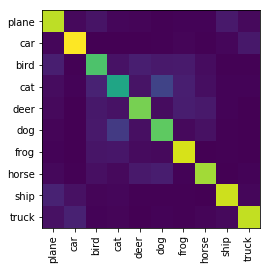

In [12]:
confusion(testloader)

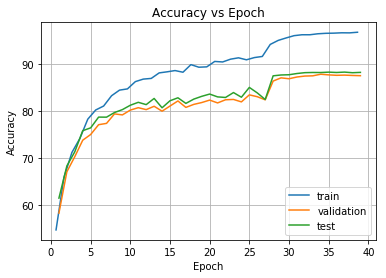

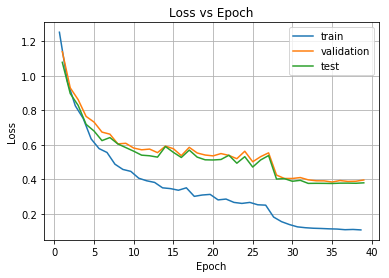

In [45]:
cur_epoch = 39
plt.figure()
plt.plot(batch_, train_accu)
plt.plot(list(range(1,cur_epoch+1)),val_accu)
plt.plot(list(range(1,cur_epoch+1)),test_accu)
plt.grid()
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','validation','test'],loc=4)

plt.figure()
plt.plot(batch_, train_loss)
plt.plot(list(range(1,cur_epoch+1)),val_loss)
plt.plot(list(range(1,cur_epoch+1)),test_loss)
plt.grid()
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','validation','test'],loc=1)

In [46]:
optimizer.param_groups[0]['lr']

1.0000000000000002e-06